In [1]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')

# 1. Time Series Classification

## 1.(a) Download the AReM dataset

In [2]:
data_root = "../data/AReM"

actvt_dirs = ["bending1", "bending2", "cycling", "lying", "sitting", "standing", "walking"]
orig_columns = ['# Columns: time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']

## 1.(b) Divide dataset into training and test sets.

In [3]:
"""
Doc Reference:
1. os.walk(): https://docs.python.org/3/library/os.html?highlight=walk#os.walk
"""

# function to traverse data folder and split file paths in to train group and test group
def split_train_test(root):
    train_files = []
    test_files = []
    for root, _, file in os.walk(data_root):
        for f in file:
            if (os.path.splitext(f)[1] == ".csv"):
                csv_idx = int(re.findall("\d+", f)[0])
                file_path = os.path.join(root, f)
                activity = os.path.split(root)[-1]
                if (csv_idx <= 2 or (activity not in ["bending1", "bending2"] and csv_idx == 3)):
                    test_files.append(file_path)
                else:
                    train_files.append(file_path)
    return train_files, test_files

In [4]:
# split instances
train_files, test_files = split_train_test(data_root)

## 1.(c) Feature Extraction

### 1.(c)-i Research what types of time-domain features are usually used in time series classification

**Ans:**

### 1.(c)-ii Extract the time-domain features minimum, maximum, mean, median, stan-dard deviation, first quartile, and third quartile for all of the 6 time series in each instance.

In [5]:
"""
Files with problem:

b'Skipping line 485: expected 7 fields, saw 8\n'
b'Skipping line 485: expected 7 fields, saw 8\n'

../data/AReM/bending2/dataset4.csv has whitespace separator
../data/AReM/cycling/dataset9.csv has one line bad ending
"""
def load_data(files, feature, orig_columns, segs=1, standard=False):
    import csv
    sniffer = csv.Sniffer()
    
    # generate columns of describes and label with indecies
    describe_order = ['mean', 'std', 'min', '_1stquart_', 'median', '_3rdquart_','max']
    desc_order_idx = [desc + str(i) for i in range(1, 6 * segs + 1) for desc in describe_order]
    
    instances  = []
    labels = []
    for csv in files:
        # get the label of the instance read from current csv
        parent_folder = os.path.dirname(csv)
        activity = os.path.split(parent_folder)[-1]
        labels.append(activity)
        
        # identidy the separater of the csv file
        sep = sniffer.sniff(open(csv).read()).delimiter
        
        # error_bad_lines=False used to 
        if sep == ",":
            cur_instance = pd.read_csv(csv, skiprows=5, header=None, 
                                       error_bad_lines=False, warn_bad_lines=False)
        else:
            cur_instance = pd.read_csv(csv, skiprows=5, header=None, sep="\s+", 
                                       error_bad_lines=False, warn_bad_lines=False)
        
        # restore the column of csv file as we skip 5th row which is headers in the csv
        # however, they will becomes mass when separater is space. Thus, skip it
        cur_instance.columns = orig_columns
        
        # break 6 time series into equal length, becomes 6*segs series
        seg_length = int(cur_instance.shape[0] / segs)
        segs_describe = []
        for i in range(segs):
            cur_seg = cur_instance[i * seg_length : min((i + 1) * seg_length, cur_instance.shape[0])]
            cur_describe = cur_seg.describe().drop('count').drop(columns="# Columns: time").T
            segs_describe.append(cur_describe.values.flatten())
        # complete current instance reading
        instances.append(np.concatenate(segs_describe, axis=None))
    
    # convert to dataframe and reorder the columns based on given feature list
    feature_df = pd.DataFrame(instances, columns=desc_order_idx)
    feature_df = feature_df.loc[:, feature]
    
    if standard:
        feature_df = feature_df.apply(lambda col: (col-col.mean()) / (np.std(col) + 1e-9), axis = 0)
    
    # add label to complete the dataset
    feature_df['label'] = pd.Series(labels)
    
    return feature_df

In [6]:
# reorder the columns
statistics = ['min','max','mean','median','std','_1stquart_', '_3rdquart_']
feature = [stat + str(i) for i in range(1, 7) for stat in statistics]

# load dataset as required
train_data = load_data(train_files, feature, orig_columns)
test_data = load_data(test_files, feature, orig_columns)

In [7]:
train_data

,min1,max1,mean1,median1,std1,_1stquart_1,_3rdquart_1,min2,max2,mean2,...,_1stquart_5,_3rdquart_5,min6,max6,mean6,median6,std6,_1stquart_6,_3rdquart_6,label
0,36.25,48.00,43.969125,44.50,1.618364,43.310,44.67,0.0,1.50,0.413125,...,20.5000,23.7500,0.0,2.96,0.555313,0.490,0.487826,0.0000,0.830,bending1
1,37.00,48.00,43.454958,43.25,1.386098,42.500,45.00,0.0,1.58,0.378083,...,22.2500,24.0000,0.0,5.26,0.679646,0.500,0.622534,0.4300,0.870,bending1
2,33.00,47.75,42.179813,43.50,3.670666,39.150,45.00,0.0,3.00,0.696042,...,30.4575,36.3300,0.0,2.18,0.613521,0.500,0.524317,0.0000,1.000,bending1
3,33.00,45.75,41.678063,41.75,2.243490,41.330,42.75,0.0,2.83,0.535979,...,28.4575,31.2500,0.0,1.79,0.383292,0.430,0.389164,0.0000,0.500,bending1
4,35.00,47.40,43.954500,44.33,1.558835,43.000,45.00,0.0,1.70,0.426250,...,35.3625,36.5000,0.0,1.79,0.493292,0.430,0.513506,0.0000,0.940,bending1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,18.50,44.25,35.752354,36.00,4.614802,33.000,39.33,0.0,12.60,3.328104,...,14.0000,18.0625,0.0,9.39,3.069667,2.770,1.748326,1.7975,4.060,cycling
65,24.25,45.00,37.177042,36.25,3.581301,34.500,40.25,0.0,8.58,2.374208,...,17.9500,21.7500,0.0,9.34,2.921729,2.500,1.852600,1.5000,3.900,cycling
66,23.33,43.50,36.248768,36.75,3.824632,33.415,39.25,0.0,9.71,2.737307,...,15.7500,21.0000,0.0,11.15,3.532463,3.110,1.965267,2.1700,4.625,cycling
67,26.25,44.25,36.957458,36.29,3.434863,34.500,40.25,0.0,8.64,2.420083,...,14.0000,18.2500,0.0,8.34,2.934625,2.525,1.631380,1.6600,4.030,cycling


In [8]:
test_data

,min1,max1,mean1,median1,std1,_1stquart_1,_3rdquart_1,min2,max2,mean2,...,_1stquart_5,_3rdquart_5,min6,max6,mean6,median6,std6,_1stquart_6,_3rdquart_6,label
0,37.25,45.00,40.624792,40.500,1.476967,39.2500,42.0000,0.0,1.30,0.358604,...,33.0000,36.0000,0.0,1.92,0.570583,0.430,0.582915,0.0000,1.300,bending1
1,38.00,45.67,42.812812,42.500,1.435550,42.0000,43.6700,0.0,1.22,0.372438,...,32.0000,34.5000,0.0,3.11,0.571083,0.430,0.601010,0.0000,1.300,bending1
2,19.33,43.50,34.227771,35.500,4.889576,30.5000,37.7500,0.0,14.50,3.995729,...,14.7500,18.6700,0.0,9.74,3.394125,3.100,1.792090,2.1050,4.425,walking
3,12.50,45.00,33.509729,34.125,4.850923,30.5000,36.7500,0.0,13.05,4.450771,...,14.6275,18.7500,0.0,8.96,3.378479,3.085,1.787360,2.0600,4.440,walking
4,15.00,46.75,34.660583,35.000,5.315110,31.0000,38.2500,0.0,13.44,4.200896,...,14.2500,18.5000,0.0,8.99,3.244396,3.000,1.630983,2.1200,4.240,walking
5,12.75,51.00,24.562958,24.250,3.737514,23.1875,26.5000,0.0,6.87,0.590833,...,20.5000,27.0000,0.0,4.97,0.700188,0.500,0.693720,0.4300,0.870,bending2
6,0.00,42.75,27.464604,28.000,3.583582,25.5000,30.0000,0.0,7.76,0.449708,...,15.0000,20.7500,0.0,6.76,1.122125,0.830,1.012342,0.4700,1.300,bending2
7,33.33,48.00,44.334729,45.000,2.476940,42.2500,46.5000,0.0,3.90,0.432958,...,9.3300,17.7500,0.0,5.02,0.933000,0.830,0.673609,0.4700,1.250,standing
8,35.50,46.25,43.174938,43.670,1.989052,42.5000,44.5000,0.0,2.12,0.506583,...,12.7500,16.5000,0.0,5.72,0.911979,0.830,0.666161,0.4700,1.220,standing
9,32.75,47.00,42.760563,44.500,3.398919,41.3300,45.3725,0.0,3.34,0.486167,...,13.0000,18.5650,0.0,5.73,0.842271,0.710,0.722165,0.4300,1.090,standing


### 1.(c)-iii Estimate the standard deviation of each of the time-domain features you extracted from the data. Build a 90% bootsrap confidence interval for the standard deviation of each feature

In [9]:
# Estimate the standard deviation
train_data.describe().loc['std']

min1           8.794295
max1           4.429182
mean1          4.917692
median1        4.956111
std1           1.758670
_1stquart_1    5.731647
_3rdquart_1    4.783645
min2           0.000000
max2           5.147841
mean2          1.600701
median2        1.436960
std2           0.902808
_1stquart_2    0.952201
_3rdquart_2    2.158416
min3           3.053869
max3           4.759853
mean3          3.863097
median3        3.845730
std3           0.995959
_1stquart_3    4.145255
_3rdquart_3    3.946023
min4           0.000000
max4           2.302408
mean4          1.179861
median4        1.150092
std4           0.473576
_1stquart_4    0.842501
_3rdquart_4    1.566564
min5           5.368786
max5           5.449726
mean5          5.120426
median5        5.267414
std5           1.057998
_1stquart_5    5.543882
_3rdquart_5    4.957231
min6           0.051766
max6           2.540166
mean6          1.171401
median6        1.104626
std6           0.519420
_1stquart_6    0.774358
_3rdquart_6    1

In [10]:
"""
Doc Refernces:
1. resample: https://scikit-learn.org/stable/modules/generated/sklearn.utils.resample.html
"""
from sklearn.utils import resample
def bootStrap(data, num_resample, operation, low=5, upper=95):
    # a list to keep all resample results
    estimation = []
    for i in range(num_resample):
        # resample the data with replacement, keep the same size of resampled data
        resampled = resample(data, replace=True, n_samples=data.shape[0])
        # get the relative statistic metric based on given operation
        estimation.append(resampled.apply(lambda col : operation(col, ddof=1), axis=0))
    # convert list to data frame and get 5%-95% percentile
    estimation = pd.DataFrame(estimation, columns=list(data.columns))
    interval = estimation.apply(lambda col : (np.percentile(col, 5), np.percentile(col, 95)), axis=0)
    return interval.apply(np.around, args=(2,))

In [11]:
# build a 90% bootsrap confidence interval
_90_intervals = bootStrap(train_data.iloc[:, :-1], 1000, np.std)
_90_intervals

min1           [7.56, 10.09]
max1            [3.24, 5.41]
mean1           [4.29, 5.42]
median1         [4.31, 5.47]
std1            [1.55, 1.94]
_1stquart_1     [5.14, 6.21]
_3rdquart_1     [3.87, 5.52]
min2              [0.0, 0.0]
max2            [4.69, 5.52]
mean2           [1.41, 1.74]
median2         [1.25, 1.58]
std2            [0.81, 0.97]
_1stquart_2     [0.83, 1.05]
_3rdquart_2     [1.91, 2.33]
min3            [2.83, 3.23]
max3            [3.99, 5.41]
mean3           [3.24, 4.42]
median3         [3.16, 4.42]
std3             [0.77, 1.2]
_1stquart_3     [3.49, 4.71]
_3rdquart_3     [3.27, 4.51]
min4              [0.0, 0.0]
max4            [2.06, 2.49]
mean4           [1.08, 1.24]
median4         [1.05, 1.21]
std4             [0.43, 0.5]
_1stquart_4      [0.76, 0.9]
_3rdquart_4     [1.43, 1.65]
min5             [3.5, 6.93]
max5            [4.32, 6.42]
mean5           [3.65, 6.41]
median5         [3.69, 6.59]
std5            [0.79, 1.29]
_1stquart_5      [4.0, 6.84]
_3rdquart_5   

### 1.(c)-iv Use your judgement to select the three most important time-domain features

In [12]:
bending_binary_train = pd.DataFrame(train_data)
bending_binary_train.loc[bending_binary_train['label'].isin(['bending1', 'bending2']), 'label'] = 1
bending_binary_train.loc[bending_binary_train['label'] != 1, 'label'] = 0
#bending_binary_train.loc[bending_binary_train['label'] == 0, '_1stquart_2']
bending_binary_train

,min1,max1,mean1,median1,std1,_1stquart_1,_3rdquart_1,min2,max2,mean2,...,_1stquart_5,_3rdquart_5,min6,max6,mean6,median6,std6,_1stquart_6,_3rdquart_6,label
0,36.25,48.00,43.969125,44.50,1.618364,43.310,44.67,0.0,1.50,0.413125,...,20.5000,23.7500,0.0,2.96,0.555313,0.490,0.487826,0.0000,0.830,1
1,37.00,48.00,43.454958,43.25,1.386098,42.500,45.00,0.0,1.58,0.378083,...,22.2500,24.0000,0.0,5.26,0.679646,0.500,0.622534,0.4300,0.870,1
2,33.00,47.75,42.179813,43.50,3.670666,39.150,45.00,0.0,3.00,0.696042,...,30.4575,36.3300,0.0,2.18,0.613521,0.500,0.524317,0.0000,1.000,1
3,33.00,45.75,41.678063,41.75,2.243490,41.330,42.75,0.0,2.83,0.535979,...,28.4575,31.2500,0.0,1.79,0.383292,0.430,0.389164,0.0000,0.500,1
4,35.00,47.40,43.954500,44.33,1.558835,43.000,45.00,0.0,1.70,0.426250,...,35.3625,36.5000,0.0,1.79,0.493292,0.430,0.513506,0.0000,0.940,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,18.50,44.25,35.752354,36.00,4.614802,33.000,39.33,0.0,12.60,3.328104,...,14.0000,18.0625,0.0,9.39,3.069667,2.770,1.748326,1.7975,4.060,0
65,24.25,45.00,37.177042,36.25,3.581301,34.500,40.25,0.0,8.58,2.374208,...,17.9500,21.7500,0.0,9.34,2.921729,2.500,1.852600,1.5000,3.900,0
66,23.33,43.50,36.248768,36.75,3.824632,33.415,39.25,0.0,9.71,2.737307,...,15.7500,21.0000,0.0,11.15,3.532463,3.110,1.965267,2.1700,4.625,0
67,26.25,44.25,36.957458,36.29,3.434863,34.500,40.25,0.0,8.64,2.420083,...,14.0000,18.2500,0.0,8.34,2.934625,2.525,1.631380,1.6600,4.030,0


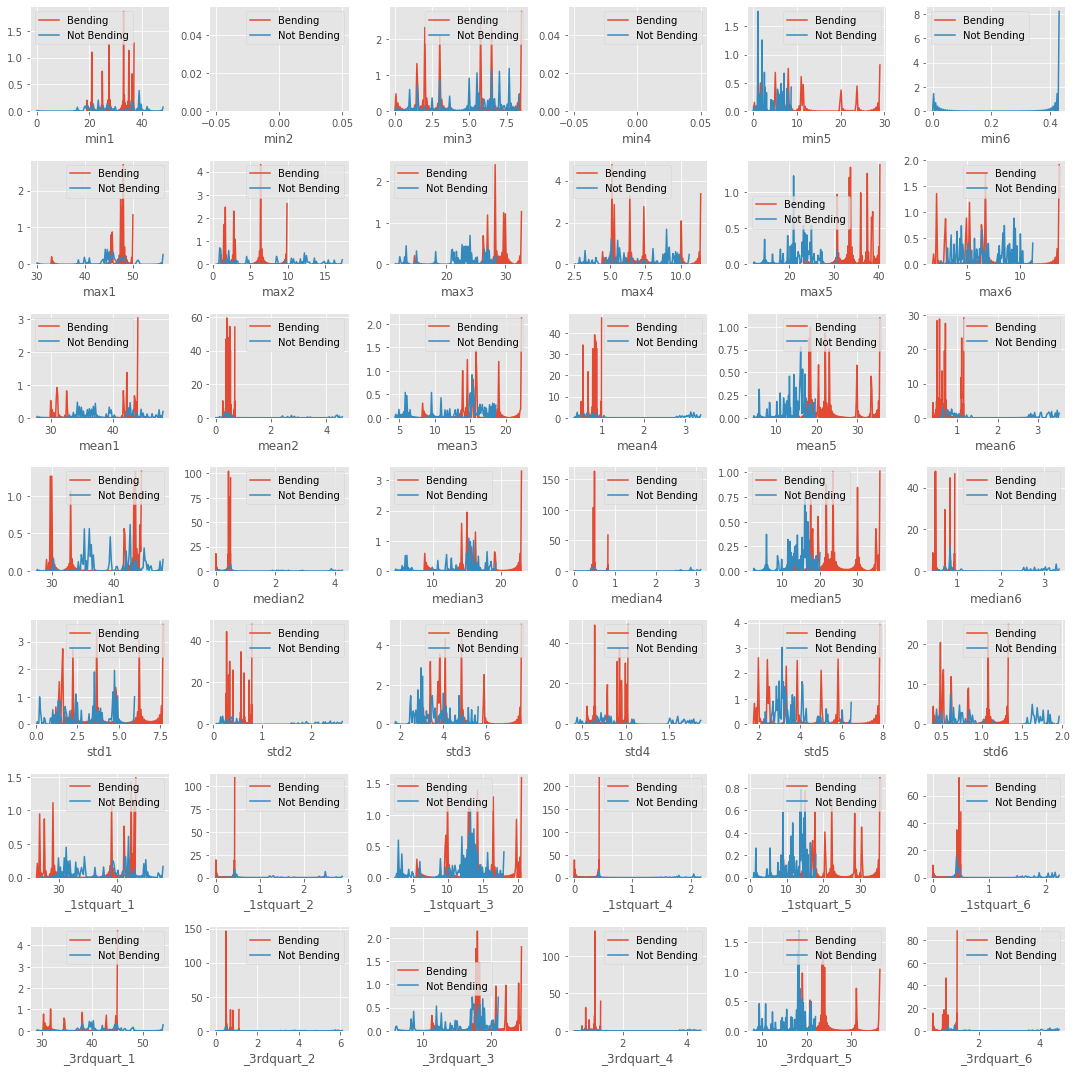

In [13]:
"""
import warning package inorder to suppress warning:
/Users/wangruihao/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.

Doc Reference: 
1. Distribution plot: https://seaborn.pydata.org/generated/seaborn.distplot.html
"""
import warnings
warnings.filterwarnings('ignore')

fig, axes = plt.subplots(7, 6, figsize=(15, 15))

for i in range(1, 7):
    for j, f in enumerate(statistics):
        sns.distplot(bending_binary_train.loc[bending_binary_train['label'] == 1, f + str(i)], 
                     kde = True, 
                     hist = False,
                     ax = axes[j, i-1],
                     label='Bending',
                     kde_kws={'bw' : 0.})
        sns.distplot(bending_binary_train.loc[bending_binary_train['label'] == 0, f + str(i)], 
                     kde = True, 
                     hist = False,
                     ax = axes[j, i-1],
                     label='Not Bending',
                     kde_kws={'bw' : 0.})
plt.tight_layout()
plt.show()

The choose of features should depend on our task. I use a binary case (bending/non-bedning classification studied in following questions) here for a easier illustration of my criteria to choose featutres:

- Smaller overlap between distributions is desired. That means a clear and relatively easier decesion boundary.
- Or more dense distribution versus a quite wide distribution. That means one class has some representitive values.

Thus, based on the principle to **relatively clear seperated distributions**, I choose max, mean and 75% as the top 3.

## 1.(d) Binary Classification Using Logistic Regression

### 1.(d)-i Depict scatter plots of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of each instance, and use color to distinguish bending vs. other activities.

In [14]:
# function to get pair plot for given series number and selected features
def pairplot(data, series_nums, select_features):
    selected_features = [f + str(i) for i in series_nums for f in select_features]
    selected_data = data[selected_features + ['label']]
    sns.pairplot(selected_data, hue='label')
    plt.show()

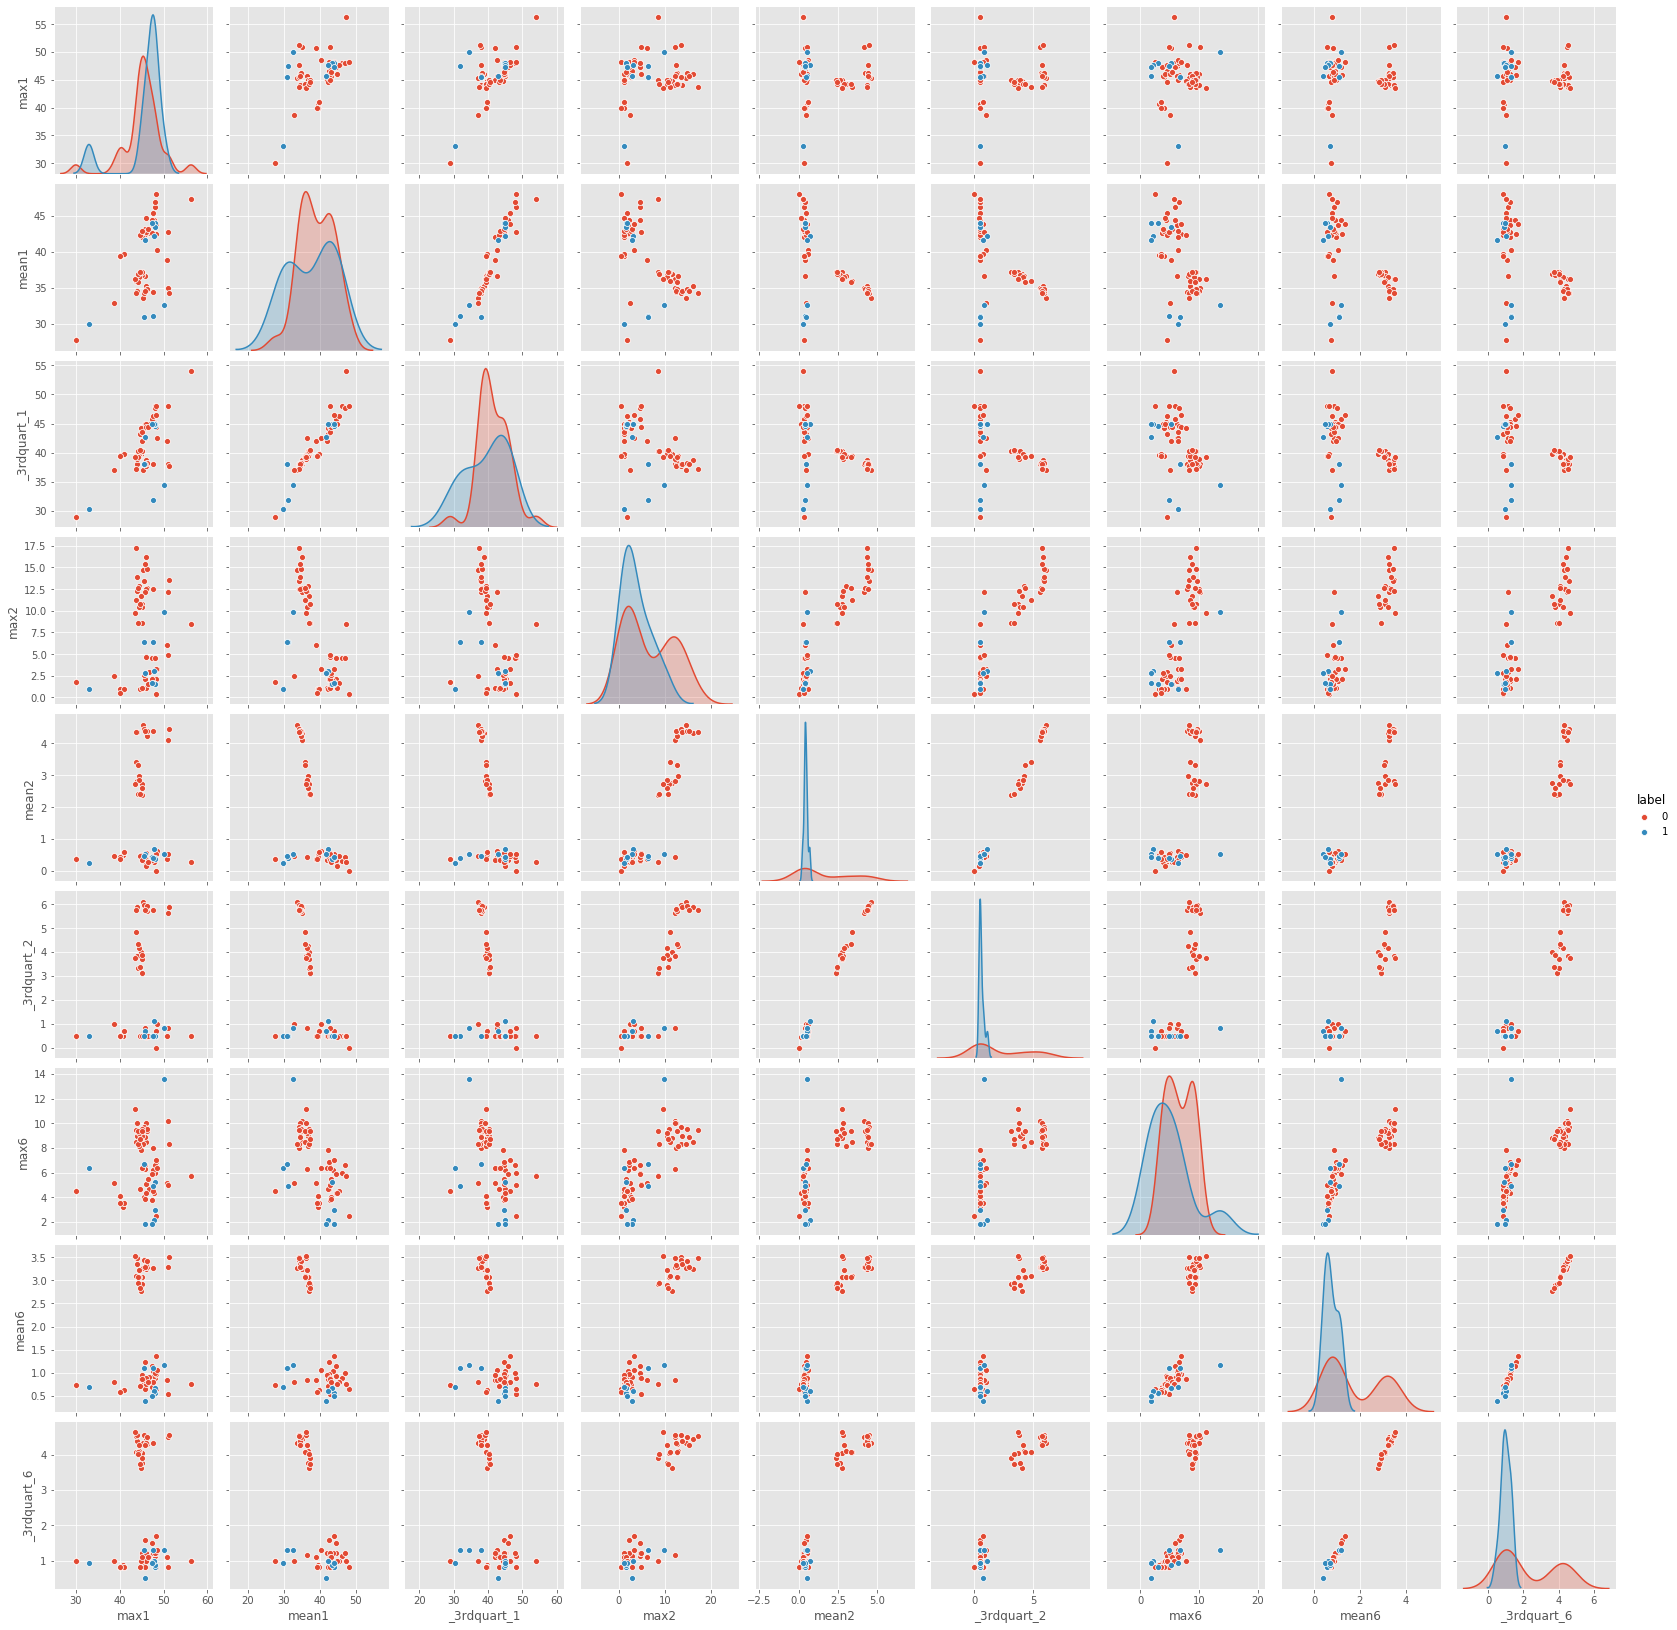

In [15]:
# Select the ['max', 'mean', '_3rdquart_'] of 1, 2 and 6 time series
pairplot(bending_binary_train, [1, 2, 6], ['max', 'mean', '_3rdquart_'])

### 1.(d)-ii Break each time series in your training set into two (approximately) equal length time series.

In [16]:
# reorder the columns
statistics = ['min','max','mean','median','std','_1stquart_', '_3rdquart_']
feature = [stat + str(i) for i in range(1, 13) for stat in statistics]

# load dataset as required: break each time series into 2 folds
train_data_2fold = load_data(train_files, feature, orig_columns, segs=2)
test_data_2fold = load_data(test_files, feature, orig_columns, segs=2)

In [17]:
bending_binary_train_2fold = pd.DataFrame(train_data_2fold)
bending_binary_train_2fold.loc[bending_binary_train_2fold['label'].isin(['bending1', 'bending2']), 'label'] = 1
bending_binary_train_2fold.loc[bending_binary_train_2fold['label'] != 1, 'label'] = 0
#bending_binary_train.loc[bending_binary_train['label'] == 0, '_1stquart_2']
bending_binary_train_2fold

,min1,max1,mean1,median1,std1,_1stquart_1,_3rdquart_1,min2,max2,mean2,...,_1stquart_11,_3rdquart_11,min12,max12,mean12,median12,std12,_1stquart_12,_3rdquart_12,label
0,36.67,45.00,43.486208,43.71,1.281976,42.3300,44.50,0.0,1.30,0.378667,...,21.000,23.5000,0.0,2.96,0.585750,0.50,0.487918,0.4225,0.8300,1
1,39.00,48.00,44.117042,45.00,1.359836,43.5000,45.00,0.0,1.30,0.250042,...,22.500,23.7500,0.0,4.06,0.543875,0.50,0.473445,0.4300,0.7100,1
2,33.75,47.75,43.278875,45.00,3.473355,42.0000,45.25,0.0,3.00,0.673292,...,28.750,33.7500,0.0,2.18,0.586083,0.47,0.491873,0.0000,0.8700,1
3,33.00,45.75,41.621208,42.33,3.118644,39.6525,44.25,0.0,2.83,0.623083,...,28.310,30.5625,0.0,1.50,0.347500,0.43,0.363144,0.0000,0.5000,1
4,36.50,46.50,44.057167,44.50,1.556971,43.2500,45.00,0.0,1.50,0.381042,...,33.000,36.2500,0.0,1.50,0.388333,0.00,0.478528,0.0000,0.7100,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,20.00,44.25,35.692167,35.50,4.643595,33.0000,39.25,0.0,11.39,3.324208,...,14.000,18.2500,0.0,8.81,2.966917,2.59,1.712062,1.8525,3.7400,0
65,24.25,45.00,36.954208,36.00,3.772836,34.2500,40.25,0.0,8.18,2.392667,...,18.000,21.6700,0.0,9.34,2.838083,2.45,1.890755,1.3825,3.8325,0
66,27.00,42.67,36.337908,36.75,3.655379,33.6700,39.00,0.0,9.71,2.698494,...,16.125,21.0000,0.0,11.15,3.530669,3.08,1.998170,2.1700,4.5150,0
67,26.25,43.40,36.865417,36.25,3.462793,34.3100,40.00,0.0,7.46,2.387250,...,14.330,18.0000,0.0,8.34,2.904458,2.57,1.609793,1.6900,3.7700,0


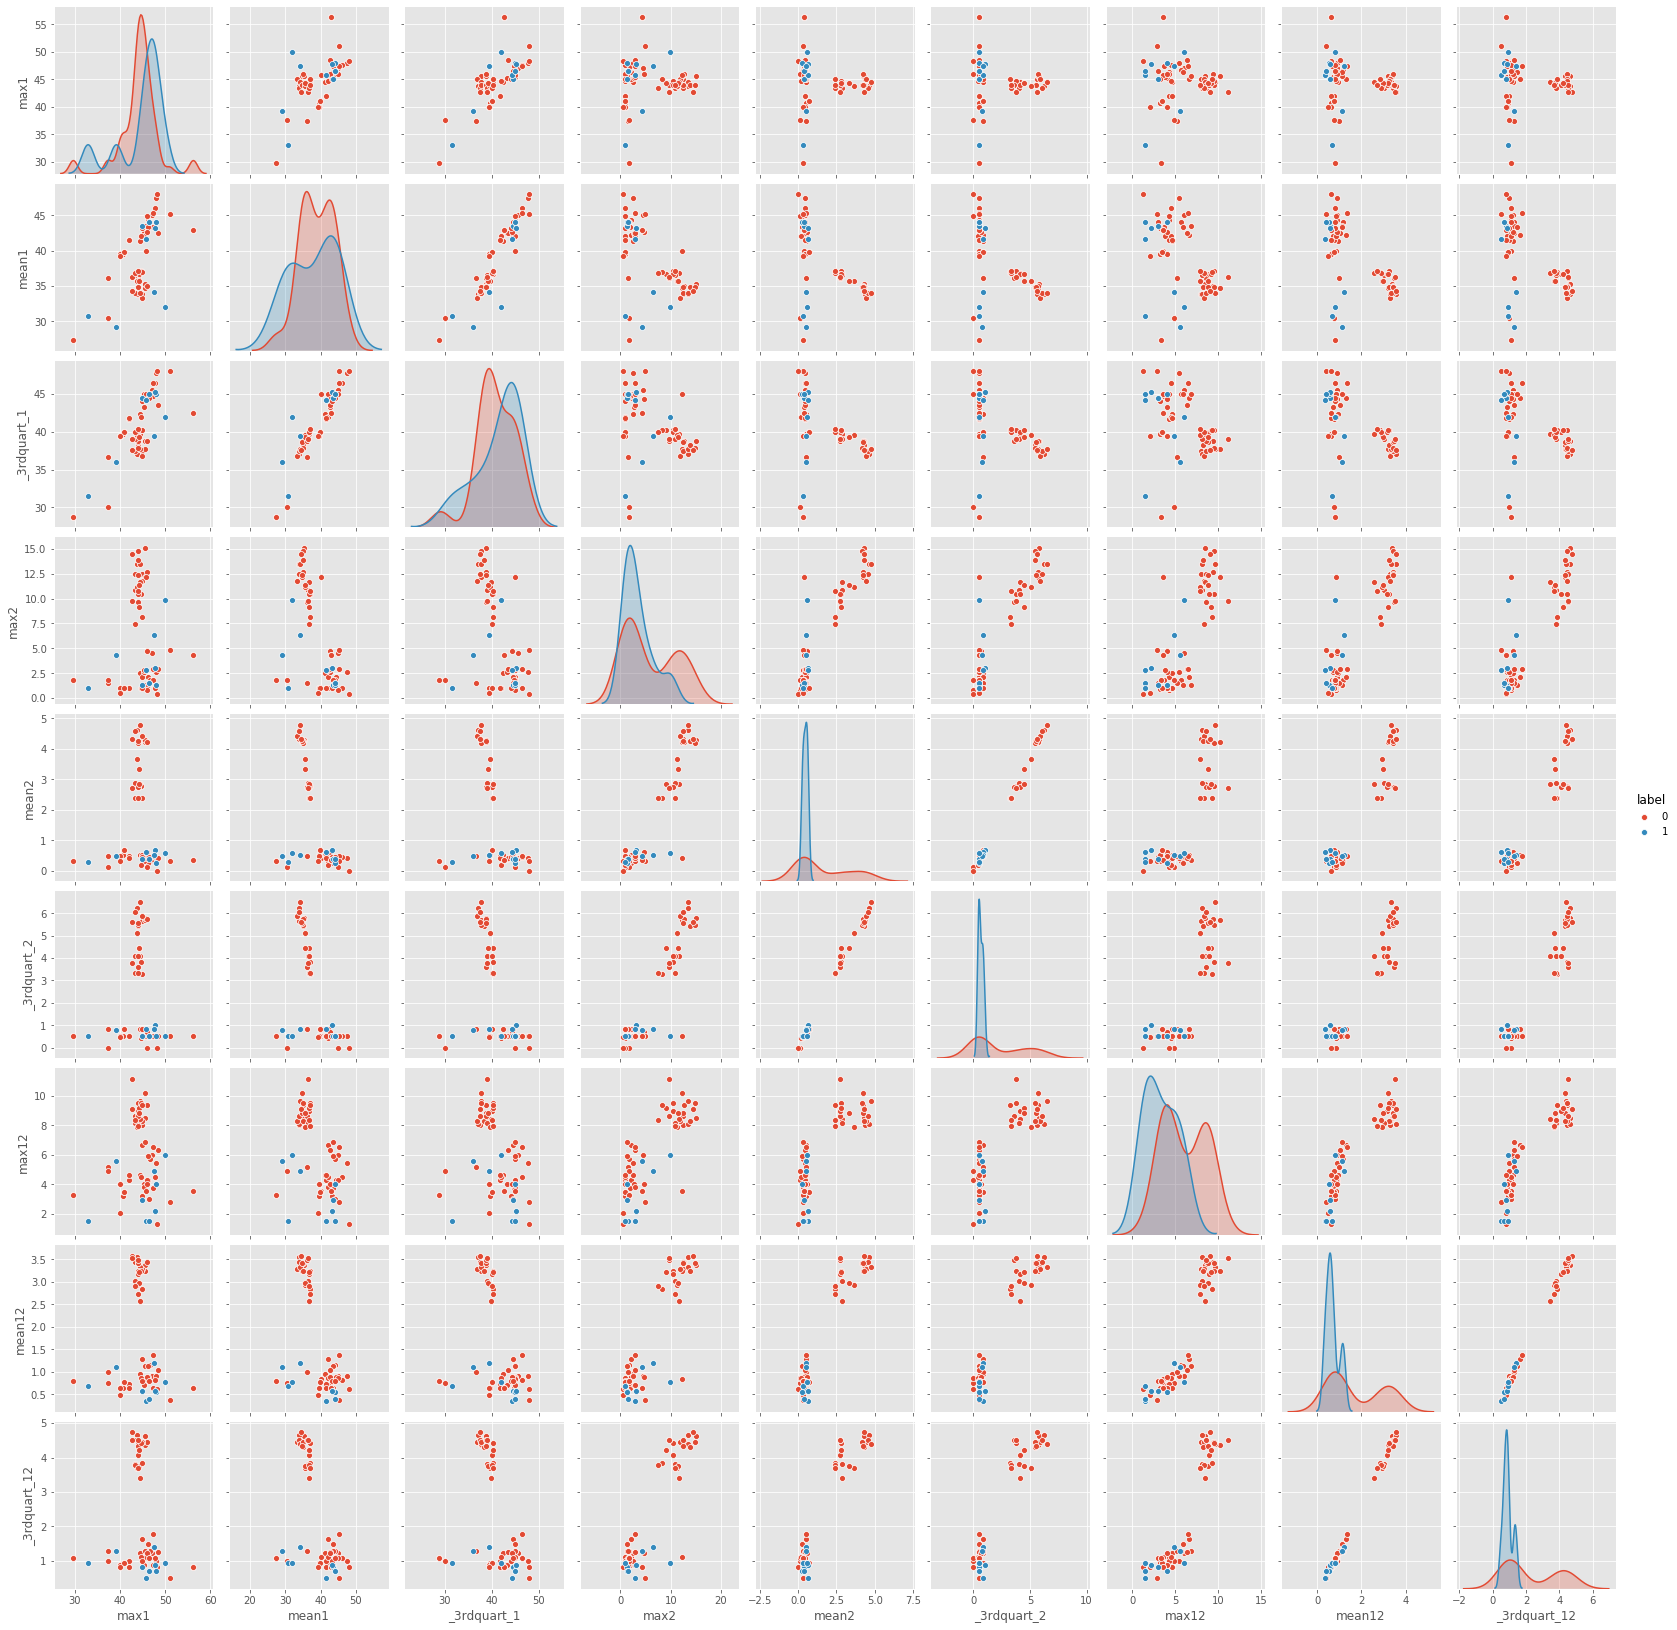

In [18]:
# Select the ['max', 'mean', '_3rdquart_'] of 1, 2 and 12 time series
pairplot(bending_binary_train_2fold, [1, 2, 12], ['max', 'mean', '_3rdquart_'])

By comparing two plots, we can see that the distributions are slightly different but look similar for the first sight.

### 1.(d)-iii Break each time series in your training set into l ∈ {1, 2, . . . , 20} time series of approximately equal length and use logistic regression5 to solve the binary classification problem, using time-domain features.

In [19]:
"""
Doc References:

1. StratifiedKFold: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
2. RFECV: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html
3. LogisticRegression: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_proba
"""


# import necessary modules
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

# perform logistic regression and cross validation for a given value of l
def logisticRegressionCV(train_files, test_files, num_fold, l, penalty, oversample):
    # specify columns
    orig_columns = ['# Columns: time', 
                    'avg_rss12', 'var_rss12', 
                    'avg_rss13', 'var_rss13', 
                    'avg_rss23', 'var_rss23']
    
    statistics = ['min','max','mean','median','std','_1stquart_', '_3rdquart_']
    feature = [stat + str(i) for i in range(1, 6 * l + 1) for stat in statistics]
    
    # load data with given value of l
    train_set = load_data(train_files, feature, orig_columns, segs=l)
    train_set.loc[train_set['label'].isin(['bending1', 'bending2']), 'label'] = "1"
    train_set.loc[train_set['label'] != "1", 'label'] = "0"
    #print(train_set)
    #test_set = load_data(test_files, feature, orig_columns, segs=l)
    
    # oversample the data if required
    if oversample:
        num_label_0 = train_set.loc[train_set['label'] == "0"].shape[0]
        num_label_1 = train_set.loc[train_set['label'] == "1"].shape[0]
        minor_count = min(num_label_0, num_label_1)
        major_count = max(num_label_0, num_label_1)
        minor_label = "1" if num_label_0 > num_label_1 else "0"
        minor = train_set.loc[train_set['label'] == minor_label]
        major = train_set.loc[train_set['label'] != minor_label]
        minor = resample(minor, replace=True, random_state=60,
                         n_samples=max(num_label_0, num_label_1))
        train_set = pd.concat([major, minor])
        print("Oversample the minority from {} to {} samples".format(minor_count, 
                                                                     major_count))
    
    # split features and labels
    trainX, trainY = train_set.iloc[:, :-1], train_set.iloc[:, -1]
    #print(trainX.shape)
    #testX, testY = test_set.iloc[:, :-1], test_set.iloc[:, -1]
    
    # create 5-fold cross validator, logistic regression classifier and featrue selector
    if penalty == 'l1':
        solver = 'liblinear'
    else:
        solver = 'lbfgs'
    validator = StratifiedKFold(n_splits=num_fold, shuffle=True, random_state=69)
    model = LogisticRegression(penalty=penalty, solver=solver, max_iter=100)
    selector = RFECV(estimator=model, cv=validator, scoring='accuracy')
    selector.fit(trainX, trainY)
    
    # return the feature selector
    return model, selector

# interate values of l from 1 to 20
def iterateL(train_files, test_files, num_fold, L, penalty='none', oversample=False):
    best_p = []
    score = []
    
    for l in range(1, L + 1):
        classifier, selector = logisticRegressionCV(train_files, test_files, 
                                                    num_fold, l, penalty=penalty,
                                                    oversample=oversample)
        best_p.append(selector.n_features_)
        score.append(selector.grid_scores_)
        #print(selector.support_)
        print("Pair {}, scores {}".format((l, best_p[-1]), 
                                          round(max(selector.grid_scores_), 4)))

In [20]:
iterateL(train_files, test_files, 5, 20)

Pair (1, 6), scores 1.0
Pair (2, 5), scores 0.9429
Pair (3, 7), scores 0.9857
Pair (4, 9), scores 0.9714
Pair (5, 3), scores 0.9857
Pair (6, 36), scores 0.9857
Pair (7, 16), scores 0.9714
Pair (8, 31), scores 0.9714
Pair (9, 43), scores 0.9857
Pair (10, 47), scores 0.9714
Pair (11, 9), scores 0.9857
Pair (12, 85), scores 0.9857
Pair (13, 12), scores 0.9857
Pair (14, 15), scores 0.9714
Pair (15, 37), scores 0.9857
Pair (16, 12), scores 0.9857
Pair (17, 11), scores 0.9857
Pair (18, 9), scores 0.9857
Pair (19, 10), scores 0.9857
Pair (20, 11), scores 0.9857


### 1.(d)-iv Report the confusion matrix and show the ROC and AUC for your classifier on train data. Report the parameters of your logistic regression $\beta_i$’s as well as the p-values associated with them.

In [21]:
"""
Doc Refrence:
1. LogisticRegressionCV: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV.score
"""

# fit model with l = 1
statistics = ['min','max','mean','median','std','_1stquart_', '_3rdquart_']
feature = [stat + str(i) for i in range(1, 6 * 1 + 1) for stat in statistics]

# get the selected feature
classifier, selector = logisticRegressionCV(train_files, test_files, 5, 1, 
                                            penalty='none', oversample=False)
selected_feature = [f for i, f in enumerate(feature) if selector.support_[i]]

selected_feature

['mean1', '_3rdquart_1', 'max2', 'min5', 'max5', '_1stquart_5']

In [22]:
# use statmodels package here to get p-values
import statsmodels.api as sm
import statsmodels.formula.api as smf

train_set = load_data(train_files, feature, orig_columns, segs=1)
train_set.loc[train_set['label'].isin(['bending1', 'bending2']), 'label'] = 1
train_set.loc[train_set['label'] != 1, 'label'] = 0
trainX, trainY = train_set.iloc[:, :-1], train_set.iloc[:, -1]

# build model, remember to add constant to features
trainX_const = sm.add_constant(trainX.loc[:, selected_feature].to_numpy(dtype=float))
#print(trainY.to_numpy())
model = sm.Logit(trainY.to_numpy(dtype=float), trainX_const)
#logitres = model.fit_regularized()
logitres = model.fit(method='bfgs')

print(logitres.summary())

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 27
         Function evaluations: 30
         Gradient evaluations: 30
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   69
Model:                          Logit   Df Residuals:                       62
Method:                           MLE   Df Model:                            6
Date:                Thu, 08 Oct 2020   Pseudo R-squ.:                   1.000
Time:                        22:21:00   Log-Likelihood:            -8.8338e-06
converged:                       True   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 9.588e-10
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7796   1.51e+07  -5.1

[[60  0]
 [ 0  9]]


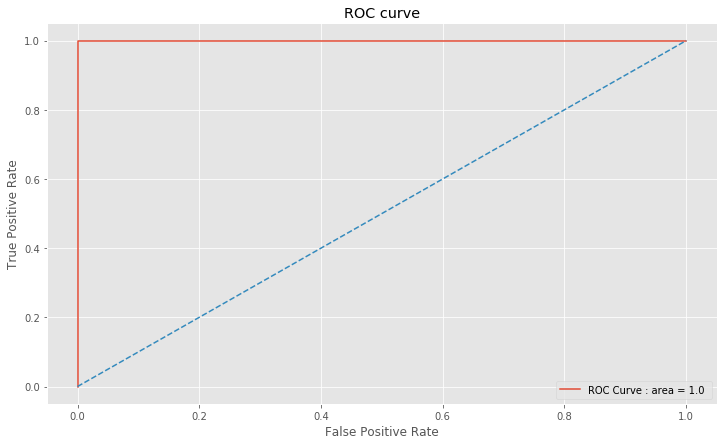

In [23]:
"""
Doc References:
1. confusion_matrix: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
2. roc_curve: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
3. auc: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html
"""

from sklearn.metrics import confusion_matrix, roc_curve, auc

# predictY = logitres.predict(trainX_const)
# fpr, tpr, thresholds = roc_curve(trainY.to_numpy(dtype=float), predictY, pos_label=1)
# print(trainY.to_numpy(dtype=float))
# print(type(predictY[0]))

classifier.fit(trainX.loc[:, selected_feature], trainY.to_numpy(dtype="int"))
predictY = classifier.predict(trainX.loc[:, selected_feature])
predictY_prob = classifier.predict_proba(trainX.loc[:, selected_feature])

fpr, tpr, thresholds = roc_curve(trainY.to_numpy(dtype="int"), predictY_prob[:, 1], pos_label=1)

conf_mat = confusion_matrix(trainY.to_numpy(dtype=float), predictY.round())
print(conf_mat)

fig, axes = plt.subplots(figsize=(12, 7))
roc_auc = auc(fpr, tpr)
axes.plot(fpr, tpr, label="ROC Curve : area = {} ".format(roc_auc))
axes.plot([0, 1], [0, 1], "--")
axes.set_xlabel("False Positive Rate")
axes.set_ylabel("True Positive Rate")
axes.legend()
axes.set_title("ROC curve")
plt.show()

### 1.(d)-v Test the classifier on the test set.

[[15  0]
 [ 0  4]]


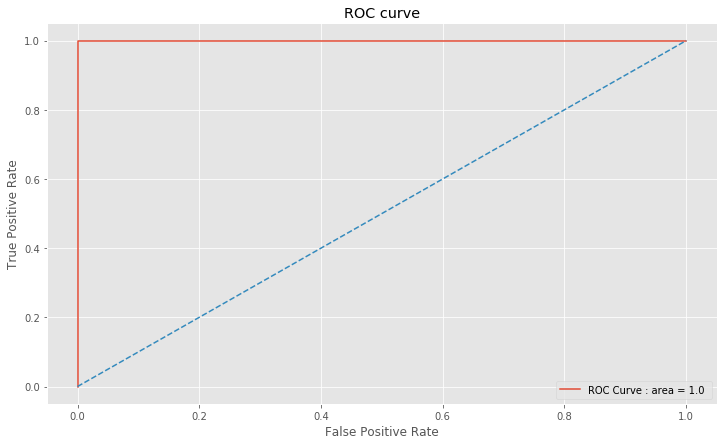

In [25]:
test_set = load_data(test_files, feature, orig_columns, segs=1)
test_set.loc[test_set['label'].isin(['bending1', 'bending2']), 'label'] = 1
test_set.loc[test_set['label'] != 1, 'label'] = 0
testX, testY = test_set.iloc[:, :-1], test_set.iloc[:, -1]

# predictY = logitres.predict(testX_const)
# testX_const = sm.add_constant(testX.loc[:, selected_feature].to_numpy(dtype=float))

# make predict use the model kept by RFECV
predictY = classifier.predict(testX.loc[:, selected_feature])
predictY_prob = classifier.predict_proba(testX.loc[:, selected_feature])

fpr, tpr, thresholds = roc_curve(testY.to_numpy(dtype="int"), predictY_prob[:, 1], pos_label=1)

# create confusion matrix
conf_mat = confusion_matrix(testY.astype(int), predictY.astype(int))
print(conf_mat)

fig, axes = plt.subplots(figsize=(12, 7))
roc_auc = auc(fpr, tpr)
axes.plot(fpr, tpr, label="ROC Curve : area = {} ".format(roc_auc))
axes.plot([0, 1], [0, 1], "--")
axes.set_xlabel("False Positive Rate")
axes.set_ylabel("True Positive Rate")
axes.legend()
axes.set_title("ROC curve")
plt.show()

In my experiment, the test accuracy is as good as the cross validation accuracy. Both are all correct.

### 1.(d)-vi Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters?

**Ans:** Yes. The summary of `statmodels` has following statement
> Complete Separation: The results show that there is complete separation.
In this case the Maximum Likelihood Estimator does not exist and the parameters
are not identified.

### 1.(d)-vii From the confusion matrices you obtained, do you see imbalanced classes? If yes, build a logistic regression model based on case-control sampling and adjust its parameters. Report the confusion matrix, ROC, and AUC of the model.

**Ans:** Yes. From confusion matrix, we can see that the number of non-bending class (60 with label 0) has significantly more sample than bending class (only 9 with label 1).

In [26]:
iterateL(train_files, test_files, 5, 20, oversample=True)

Oversample the minority from 9 to 60 samples
Pair (1, 4), scores 1.0
Oversample the minority from 9 to 60 samples
Pair (2, 7), scores 0.9833
Oversample the minority from 9 to 60 samples
Pair (3, 3), scores 1.0
Oversample the minority from 9 to 60 samples
Pair (4, 3), scores 0.9917
Oversample the minority from 9 to 60 samples
Pair (5, 3), scores 0.9917
Oversample the minority from 9 to 60 samples
Pair (6, 3), scores 0.9917
Oversample the minority from 9 to 60 samples
Pair (7, 2), scores 0.9917
Oversample the minority from 9 to 60 samples
Pair (8, 3), scores 0.9917
Oversample the minority from 9 to 60 samples
Pair (9, 9), scores 1.0
Oversample the minority from 9 to 60 samples
Pair (10, 6), scores 1.0
Oversample the minority from 9 to 60 samples
Pair (11, 2), scores 0.9917
Oversample the minority from 9 to 60 samples
Pair (12, 4), scores 0.9917
Oversample the minority from 9 to 60 samples
Pair (13, 4), scores 1.0
Oversample the minority from 9 to 60 samples
Pair (14, 7), scores 1.0
Overs

In [27]:
# fit model with l = 1
statistics = ['min','max','mean','median','std','_1stquart_', '_3rdquart_']
feature = [stat + str(i) for i in range(1, 6 * 1 + 1) for stat in statistics]

# get the selected feature
classifier, selector = logisticRegressionCV(train_files, test_files, 5, 1, 
                                            penalty='none', oversample=True)
selected_feature = [f for i, f in enumerate(feature) if selector.support_[i]]

selected_feature

Oversample the minority from 9 to 60 samples


['_3rdquart_1', 'min5', 'max5', 'mean5']

Oversample the minority from 9 to 60 samples
[[60  0]
 [ 0 60]]


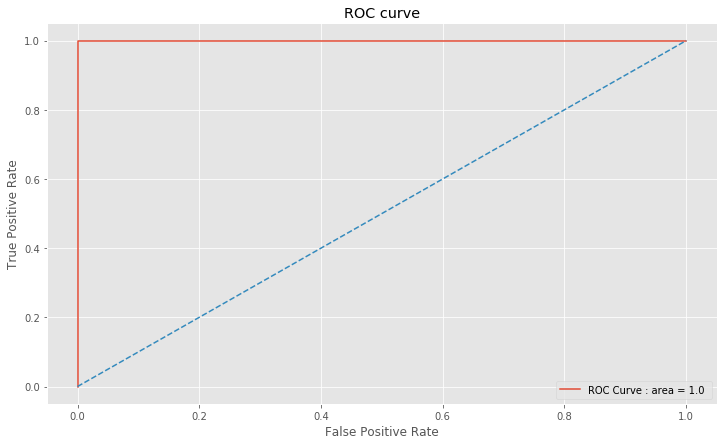

In [28]:
# load original data
train_set = load_data(train_files, feature, orig_columns, segs=1)
train_set.loc[train_set['label'].isin(['bending1', 'bending2']), 'label'] = 1
train_set.loc[train_set['label'] != 1, 'label'] = 0

# oversample
num_label_0 = train_set.loc[train_set['label'] == 0].shape[0]
num_label_1 = train_set.loc[train_set['label'] == 1].shape[0]
minor_count = min(num_label_0, num_label_1)
major_count = max(num_label_0, num_label_1)
minor_label = 1 if num_label_0 > num_label_1 else 0
minor = train_set.loc[train_set['label'] == minor_label]
major = train_set.loc[train_set['label'] != minor_label]
minor = resample(minor, replace=True, 
                         n_samples=max(num_label_0, num_label_1))
train_set = pd.concat([major, minor])
print("Oversample the minority from {} to {} samples".format(minor_count, 
                                                            major_count))

trainX, trainY = train_set.iloc[:, :-1], train_set.iloc[:, -1]

classifier.fit(trainX.loc[:, selected_feature], trainY.to_numpy(dtype="int"))
predictY = classifier.predict(trainX.loc[:, selected_feature])
predictY_prob = classifier.predict_proba(trainX.loc[:, selected_feature])

fpr, tpr, thresholds = roc_curve(trainY.to_numpy(dtype="int"), predictY_prob[:, 1], pos_label=1)

conf_mat = confusion_matrix(trainY.to_numpy(dtype=float), predictY.round())
print(conf_mat)

fig, axes = plt.subplots(figsize=(12, 7))
roc_auc = auc(fpr, tpr)
axes.plot(fpr, tpr, label="ROC Curve : area = {} ".format(roc_auc))
axes.plot([0, 1], [0, 1], "--")
axes.set_xlabel("False Positive Rate")
axes.set_ylabel("True Positive Rate")
axes.legend()
axes.set_title("ROC curve")
plt.show()

[[15  0]
 [ 0  4]]


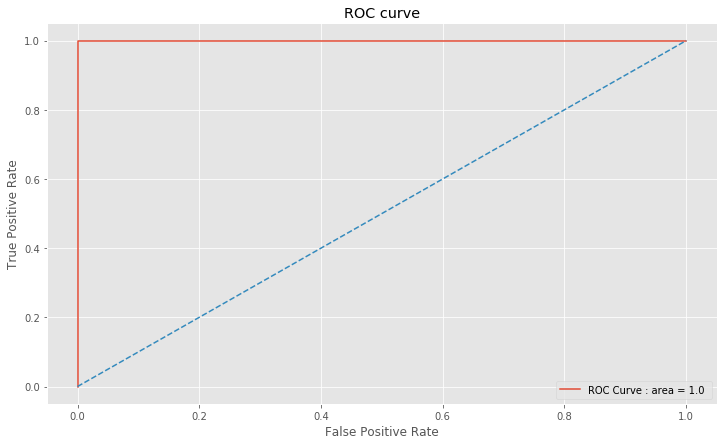

In [29]:
test_set = load_data(test_files, feature, orig_columns, segs=1)
test_set.loc[test_set['label'].isin(['bending1', 'bending2']), 'label'] = 1
test_set.loc[test_set['label'] != 1, 'label'] = 0
testX, testY = test_set.iloc[:, :-1], test_set.iloc[:, -1]

# make predict use the model kept by RFECV
predictY = classifier.predict(testX.loc[:, selected_feature])
predictY_prob = classifier.predict_proba(testX.loc[:, selected_feature])

# create confusion matrix
conf_mat = confusion_matrix(testY.astype(int), predictY.astype(int))
print(conf_mat)

# plot ROC curve for test set
fpr, tpr, thresholds = roc_curve(testY.to_numpy(dtype="int"), predictY_prob[:, 1], pos_label=1)

fig, axes = plt.subplots(figsize=(12, 7))
roc_auc = auc(fpr, tpr)
axes.plot(fpr, tpr, label="ROC Curve : area = {} ".format(roc_auc))
axes.plot([0, 1], [0, 1], "--")
axes.set_xlabel("False Positive Rate")
axes.set_ylabel("True Positive Rate")
axes.legend()
axes.set_title("ROC curve")
plt.show()

## 1.(e) Binary Classification Using L1-penalized logistic regression

### 1.(e)-i. Repeat 1(d)iii using L1-penalized logistic regression,8 i.e. instead of using p-values for variable selection, use L1 regularization.

In [30]:
# function to perform cross validation and find optimal l 
# with given classifier and specified paramter settings
def iterateLWithClf(classifier_obj, kwargs, binary_classes):
    for l in range(1, 20 + 1):
        # specify columns
        orig_columns = ['# Columns: time', 
                        'avg_rss12', 'var_rss12', 
                        'avg_rss13', 'var_rss13', 
                        'avg_rss23', 'var_rss23']
        
        statistics = ['min','max','mean','median','std','_1stquart_', '_3rdquart_']
        feature = [stat + str(i) for i in range(1, 6 * l + 1) for stat in statistics]
        
        # load data with given value of l
        train_set = load_data(train_files, feature, orig_columns, segs=l)
        test_set = load_data(test_files, feature, orig_columns, segs=l)
        
        # relabel the instance if it is binary classification
        if binary_classes:
            train_set.loc[train_set['label'].isin(['bending1', 'bending2']), 'label'] = "1"
            train_set.loc[train_set['label'] != "1", 'label'] = "0"
            test_set.loc[test_set['label'].isin(['bending1', 'bending2']), 'label'] = "1"
            test_set.loc[test_set['label'] != "1", 'label'] = "0"
        
        # split feature and label
        trainX, trainY = train_set.iloc[:, :-1], train_set.iloc[:, -1]
        testX, testY = test_set.iloc[:, :-1], test_set.iloc[:, -1]
        
        # build the classifier and fit the data
        classifier = classifier_obj(**kwargs)
        classifier.fit(trainX, trainY)
        
        # calculate the scores
        train_score = classifier.score(trainX, trainY)
        test_score = classifier.score(testX, testY)
        
        print("Value of l ~ {} : train scores {}, test score {}".format(l, 
                                                     round(train_score, 4), 
                                                     round(test_score, 4)))

        
# function to plot ROC curves
def plotROC(classifier, groudTruthY, predictY_prob, title):
    fig, axes = plt.subplots(figsize=(12, 7))
    for i, c in enumerate(classifier.classes_):
        fpr, tpr, thresholds = roc_curve(groudTruthY, predictY_prob[:, i], pos_label=c)
        roc_auc = auc(fpr, tpr)
        axes.plot(fpr, tpr, label="ROC Curve of {} : area = {} ".format(c, round(roc_auc, 4)))
    axes.plot([0, 1], [0, 1], "--")
    axes.set_xlabel("False Positive Rate")
    axes.set_ylabel("True Positive Rate")
    axes.legend()
    axes.set_title("ROC curves of {}".format(title))
    plt.show()


def useOptimLonTest(l, classifier, kwargs, binary_classes):
    # specify columns
    orig_columns = ['# Columns: time', 
                    'avg_rss12', 'var_rss12', 
                    'avg_rss13', 'var_rss13', 
                    'avg_rss23', 'var_rss23']
    
    statistics = ['min','max','mean','median','std','_1stquart_', '_3rdquart_']
    feature = [stat + str(i) for i in range(1, 6 * l + 1) for stat in statistics]
    
    train_set = load_data(train_files, feature, orig_columns, segs=l)
    test_set = load_data(test_files, feature, orig_columns, segs=l)
    
    # relabel the instance if it is binary classification
    if binary_classes:
        train_set.loc[train_set['label'].isin(['bending1', 'bending2']), 'label'] = "1"
        train_set.loc[train_set['label'] != "1", 'label'] = "0"
        test_set.loc[test_set['label'].isin(['bending1', 'bending2']), 'label'] = "1"
        test_set.loc[test_set['label'] != "1", 'label'] = "0"
    
    trainX, trainY = train_set.iloc[:, :-1], train_set.iloc[:, -1]
    testX, testY = test_set.iloc[:, :-1], test_set.iloc[:, -1]
    
    # the new constructed model
    classifier = classifier(**kwargs)
    classifier.fit(trainX, trainY)
    
    # get prediction probability for both train and test, this is used to get ROC curve
    train_predictY_prob = classifier.predict_proba(trainX)
    predictY_prob = classifier.predict_proba(testX)
    
    # get prediction of test set and its confusion matrix
    predictY = classifier.predict(testX)
    conf_mat = confusion_matrix(testY, predictY)
    print("Confusion matrix on test set:\n{}".format(conf_mat))
    
    # plot ROC for multiple classes
    plotROC(classifier, trainY, train_predictY_prob, "Train Set")
    plotROC(classifier, testY, predictY_prob, "Test Set")

In [31]:
# logistic regression with L1 penalty
from sklearn.linear_model import LogisticRegressionCV

# parameter settings to create model
kwargs = {
    'penalty' : 'l1', 
    'max_iter' : 100,
    'scoring' : 'accuracy',
    'cv' : 5,
    'random_state' : 69,
    'solver' : 'liblinear'
}

iterateLWithClf(LogisticRegressionCV, kwargs, binary_classes=True)

Value of l ~ 1 : train scores 1.0, test score 1.0
Value of l ~ 2 : train scores 1.0, test score 1.0
Value of l ~ 3 : train scores 1.0, test score 1.0
Value of l ~ 4 : train scores 1.0, test score 0.9474
Value of l ~ 5 : train scores 1.0, test score 0.9474
Value of l ~ 6 : train scores 1.0, test score 0.9474
Value of l ~ 7 : train scores 1.0, test score 1.0
Value of l ~ 8 : train scores 1.0, test score 0.9474
Value of l ~ 9 : train scores 1.0, test score 0.9474
Value of l ~ 10 : train scores 1.0, test score 0.9474
Value of l ~ 11 : train scores 1.0, test score 0.9474
Value of l ~ 12 : train scores 1.0, test score 1.0
Value of l ~ 13 : train scores 1.0, test score 1.0
Value of l ~ 14 : train scores 1.0, test score 0.9474
Value of l ~ 15 : train scores 1.0, test score 0.9474
Value of l ~ 16 : train scores 1.0, test score 0.9474
Value of l ~ 17 : train scores 1.0, test score 0.9474
Value of l ~ 18 : train scores 1.0, test score 0.9474
Value of l ~ 19 : train scores 1.0, test score 0.9474
V

Confusion matrix on test set:
[[15  0]
 [ 0  4]]


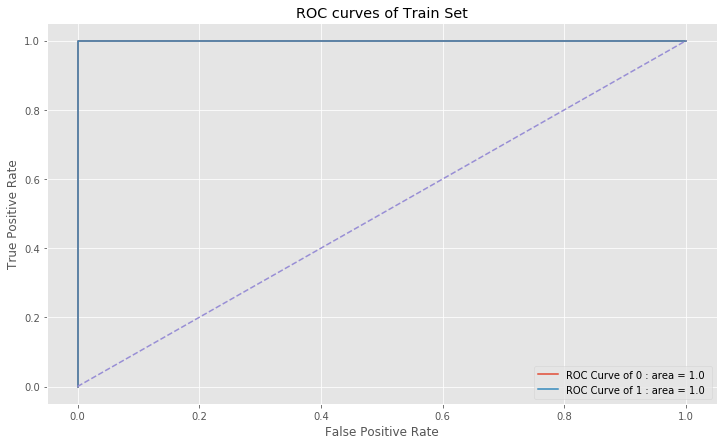

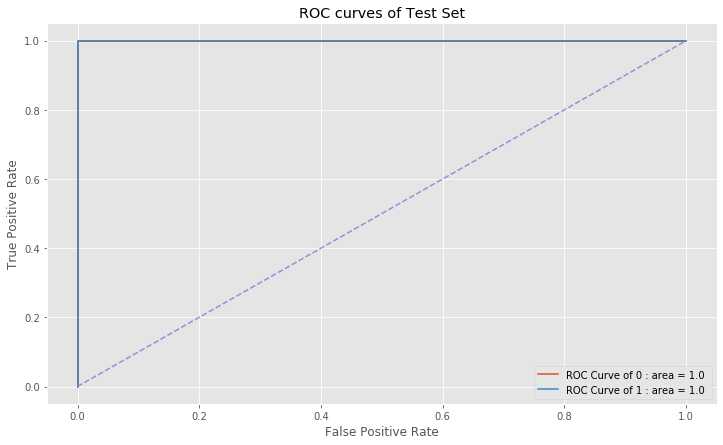

In [32]:
kwargs = {
    'penalty' : 'l1', 
    'max_iter' : 100, 
    'solver' : 'liblinear'
}

useOptimLonTest(1, LogisticRegression, kwargs, binary_classes=True)

### 1.(e)-ii. Compare the L1-penalized with variable selection using p-values. Which one performs better? Which one is easier to implement?

**Ans:** 
- Bsed on the logged cross validation score during model iterations, we can see that the L1-penalized model has a better performance on cross validation and a pretty good score (1.0 accuracy) for test set as well. 
- The L1-regularization should be easier for implementation because, unlike selection using p-value, we do not need to mannually select the features after an intensive computing of p-values. The sharper edges of L1 constrain helps to select features. 

## 1.(f) Multi-class Classification

### 1.(f)-i Find the best l in the same way as you found it in 1(e)i to build an L1- penalized multinomial regression model to classify all activities in your training set cross-validation for λ automatically.

In [33]:
kwargs = {
    'penalty' : 'l1', 
    'max_iter' : 100,
    'multi_class' : 'multinomial',
    'cv' : 5,
    'random_state' : 69,
    'solver' : 'saga'
}

iterateLWithClf(LogisticRegressionCV, kwargs, binary_classes=False)

Value of l ~ 1 : train scores 1.0, test score 0.8947
Value of l ~ 2 : train scores 1.0, test score 0.9474
Value of l ~ 3 : train scores 1.0, test score 0.8421
Value of l ~ 4 : train scores 1.0, test score 0.8947
Value of l ~ 5 : train scores 1.0, test score 0.8421
Value of l ~ 6 : train scores 1.0, test score 0.7895
Value of l ~ 7 : train scores 1.0, test score 0.7368
Value of l ~ 8 : train scores 1.0, test score 0.7895
Value of l ~ 9 : train scores 0.9855, test score 0.7895
Value of l ~ 10 : train scores 1.0, test score 0.8421
Value of l ~ 11 : train scores 1.0, test score 0.7895
Value of l ~ 12 : train scores 1.0, test score 0.7895
Value of l ~ 13 : train scores 0.9855, test score 0.7895
Value of l ~ 14 : train scores 1.0, test score 0.8421
Value of l ~ 15 : train scores 1.0, test score 0.7895
Value of l ~ 16 : train scores 1.0, test score 0.7895
Value of l ~ 17 : train scores 0.9855, test score 0.7895
Value of l ~ 18 : train scores 1.0, test score 0.7895
Value of l ~ 19 : train scor

We choose $l = 2$ as the best option as it has the highest test score.

Confusion matrix on test set:
[[2 0 0 0 0 0 0]
 [0 1 1 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 0 0 3 0]
 [0 0 0 0 0 0 3]]


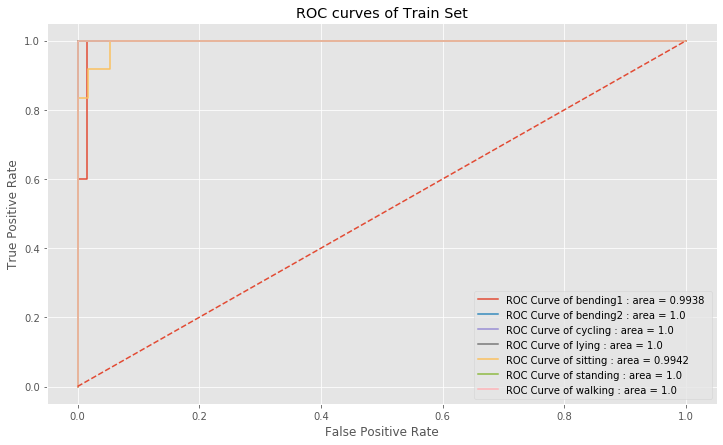

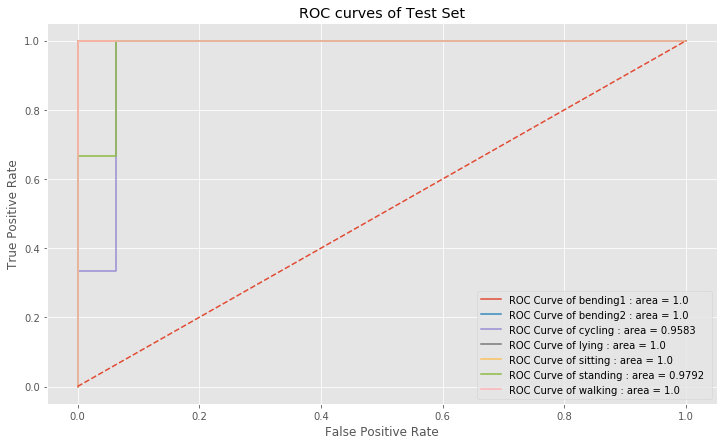

In [34]:
kwargs = {
    'penalty' : 'l1', 
    'max_iter' : 100, 
    'multi_class' : 'multinomial', 
    'solver' : 'saga'
}

useOptimLonTest(2, LogisticRegression, kwargs, binary_classes=False)

### 1.(f)-ii Repeat 1(f)i using a Naive Bayes’ classifier. Use both Gaussian and Multi- nomial priors and compare the results.

In [35]:
"""
Doc references:
1. GaussianNB: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html
"""

from sklearn.naive_bayes import GaussianNB

iterateLWithClf(GaussianNB, {}, binary_classes=False)

Value of l ~ 1 : train scores 1.0, test score 0.8947
Value of l ~ 2 : train scores 1.0, test score 0.6316
Value of l ~ 3 : train scores 0.9855, test score 0.7368
Value of l ~ 4 : train scores 1.0, test score 0.7895
Value of l ~ 5 : train scores 0.9855, test score 0.7895
Value of l ~ 6 : train scores 0.971, test score 0.6316
Value of l ~ 7 : train scores 1.0, test score 0.7368
Value of l ~ 8 : train scores 0.9855, test score 0.7368
Value of l ~ 9 : train scores 1.0, test score 0.6842
Value of l ~ 10 : train scores 1.0, test score 0.7895
Value of l ~ 11 : train scores 0.9855, test score 0.6842
Value of l ~ 12 : train scores 1.0, test score 0.6316
Value of l ~ 13 : train scores 1.0, test score 0.7368
Value of l ~ 14 : train scores 1.0, test score 0.5789
Value of l ~ 15 : train scores 1.0, test score 0.5789
Value of l ~ 16 : train scores 1.0, test score 0.5263
Value of l ~ 17 : train scores 1.0, test score 0.5263
Value of l ~ 18 : train scores 1.0, test score 0.6842
Value of l ~ 19 : train

Confusion matrix on test set:
[[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 2 1 0 0]
 [0 0 0 0 3 0 0]
 [0 0 0 0 1 2 0]
 [0 0 0 0 0 0 3]]


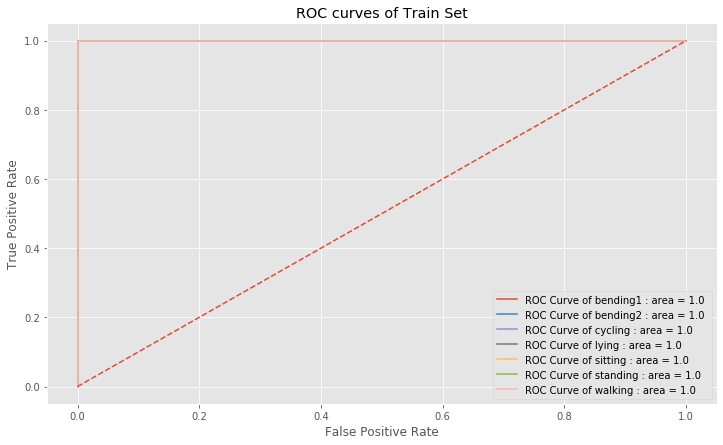

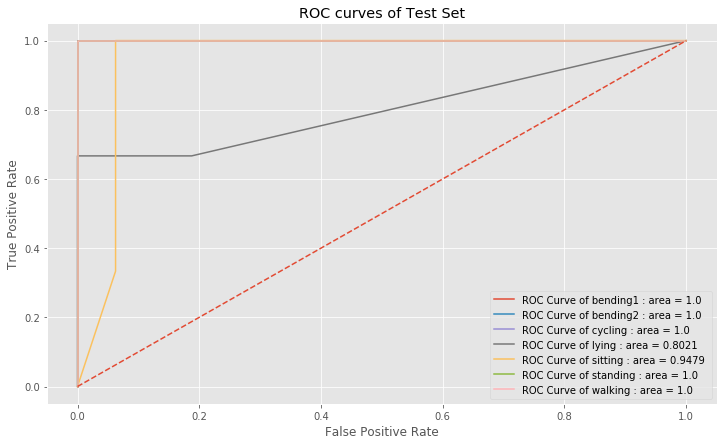

In [36]:
useOptimLonTest(1, GaussianNB, {}, binary_classes=False)

In [37]:
"""
Doc references:
1. MultinomialNB: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
"""

from sklearn.naive_bayes import MultinomialNB

iterateLWithClf(MultinomialNB, {}, binary_classes=False)

Value of l ~ 1 : train scores 0.9275, test score 0.8947
Value of l ~ 2 : train scores 0.8841, test score 0.7368
Value of l ~ 3 : train scores 0.8986, test score 0.7895
Value of l ~ 4 : train scores 0.913, test score 0.7895
Value of l ~ 5 : train scores 0.9275, test score 0.7368
Value of l ~ 6 : train scores 0.9565, test score 0.7368
Value of l ~ 7 : train scores 0.942, test score 0.7368
Value of l ~ 8 : train scores 0.942, test score 0.7368
Value of l ~ 9 : train scores 0.942, test score 0.7368
Value of l ~ 10 : train scores 0.942, test score 0.7368
Value of l ~ 11 : train scores 0.942, test score 0.7368
Value of l ~ 12 : train scores 0.942, test score 0.7368
Value of l ~ 13 : train scores 0.942, test score 0.7895
Value of l ~ 14 : train scores 0.942, test score 0.7895
Value of l ~ 15 : train scores 0.942, test score 0.7895
Value of l ~ 16 : train scores 0.942, test score 0.7895
Value of l ~ 17 : train scores 0.942, test score 0.8421
Value of l ~ 18 : train scores 0.942, test score 0.8

Confusion matrix on test set:
[[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 1 0 2 0]
 [0 0 0 0 0 0 3]]


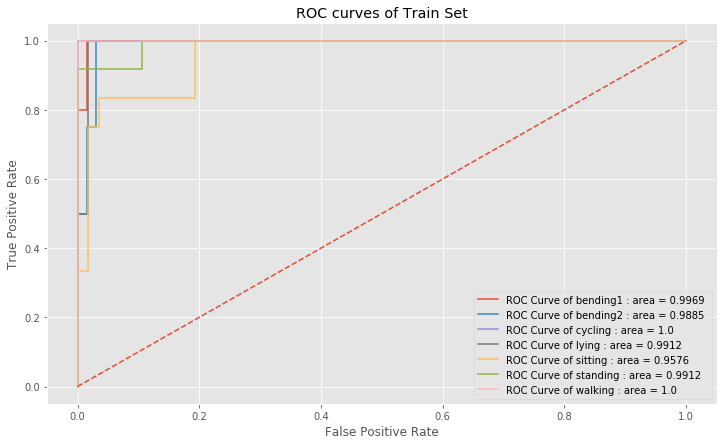

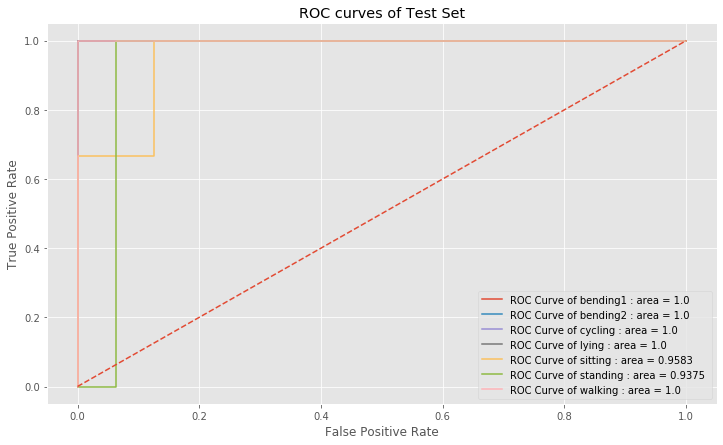

In [38]:
useOptimLonTest(1, MultinomialNB, {}, binary_classes=False)

### 1.(f)-iii Which method is better for multi-class classification in this problem?

**Ans:** From the reported results above, the three models have the same error rate on test set (2 misclassified samples). However, we can see that the logistic regression has a better ROC curves whose AUC are larger for all classes. That means the logistic regression has a relatively better classification performance for this dataset.

# 2. ISLR 3.7.4

I collect a set of data (n = 100 observations) containing a single predictor and a quantitative response. I then fit a linear regression model to the data, as well as a separate cubic regression, i.e. Y = β0 +β1X +β2X2 +β3X3 +ε.

(a) Suppose that the true relationship between X and Y is linear, i.e. Y = β0 + β1X + ε. Consider the training residual sum of squares (RSS) for the linear regression, and also the training RSS for the cubic regression. Would we expect one to be lower than the other, would we expect them to be the same, or is there not enough information to tell? Justify your answer.

**Ans:** _I will expect that cubid regression has a lower RSS than linear one beacause more predictors means a better fitting for training data._


(b) Answer (a) using test rather than training RSS.

**Ans:** _As the cubia regression with high order terms and more predictors, it will suffer overffiting. Thus, for test RSS, I will expect a lower RSS for the linear regression._


(c) Suppose that the true relationship between X and Y is not linear, but we don’t know how far it is from linear. Consider the training RSS for the linear regression, and also the training RSS for the cubic regression. Would we expect one to be lower than the other, would we expect them to be the same, or is there not enough information to tell? Justify your answer.

**Ans:** _Even though the true relationship is unkonwn, the a cubic regression still has better flexibility with more predictor. So, its training RSS will be still smaller one._


(d) Answer (c) using test rather than training RSS.

**Ans:** _That depends in which regression the true relation is closer to. The infromation is not enough for us to determine the level of flexibility we need in our model._

# 3. ISLR 4.7.3

This problem relates to the QDA model, in which the observations within each class are drawn from a normal distribution with a class-specific mean vector and a class specific covariance matrix. We consider the simple case where p = 1; i.e. there is only one feature.

Suppose that we have K classes, and that if an observation belongs to the kth class then X comes from a one-dimensional normal distribution, X ∼ N(μk,σk2). Recall that the density function for the one-dimensional normal distribution is given in (4.11). Prove that in this case, the Bayes’ classifier is not linear. Argue that it is in fact quadratic.

**Ans:**

<img src="https://drive.google.com/uc?id=1Er97GQXXaobYyYDBahRmXJcYPYIPnm_J&export=download">

# 4. ISLR 4.7.7

Suppose that we wish to predict whether a given stock will issue a dividend this year (“Yes” or “No”) based on X, last year’s percent profit. We examine a large number of companies and discover that the mean value of X for companies that issued a dividend was $\bar{X}$ = 10, while the mean for those that didn’t was $\bar{X}$ = 0. In addition, the variance of X for these two sets of companies was σˆ2 = 36. Finally, 80 % of companies issued dividends. Assuming that X follows a nor- mal distribution, predict the probability that a company will issue a dividend this year given that its percentage profit was X = 4 last year.

**Ans:**
<img src="https://drive.google.com/uc?id=1h7utd64zxzny7mVfmgvCmQIcvIipRS4H&export=download">